In [1]:
!unzip -q drive/MyDrive/DCGAN/archive.zip

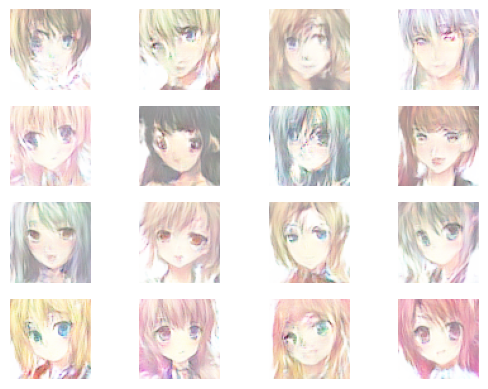

Time for epoch 75 is 77.2497227191925 sec
Gen Loss: 1.3505176305770874, Dis Real Loss: 0.7269676923751831, Dis Fake Loss: 0.4713139533996582


 91%|█████████ | 153/169 [01:10<00:05,  3.09it/s]

In [ ]:
import time
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from typing import Union
from IPython import display
import matplotlib.pyplot as plt
from tensorflow.keras import layers

IMG_DIM = 64
IMG_CHANNEL = 3
EPOCHS = 2000
LATENT_DIM = 100
BATCH_SIZE = 128
TEST_SAMPLE_SIZE = 16

def read_data(data_path:str, batch_size:int=128, img_dim:int=64, normalize:bool=True) -> tf.data.Dataset:
    """
    Read image data from directory.
        data_path: directory path of images
        batch_size: batch size of dataset
        img_dim: image dimension (square)
        normalize: normalize data or not
    """
    dataset = tf.keras.utils.image_dataset_from_directory(data_path, batch_size=batch_size)
    if normalize:
        normalization_layer = tf.keras.layers.Rescaling(1 / 255)
        dataset = dataset.map(lambda x, y: (normalization_layer(x), y))
    dataset = dataset.map(lambda x, y: (tf.image.resize(x, [img_dim, img_dim]), y))
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), y))
    dataset = dataset.shuffle(len(dataset), reshuffle_each_iteration=True)
    return dataset

def generator_model(IMG_DIM:int, IMG_CHANNEL:int, LATENT_DIM:int) -> tf.Module:
    """
    Create generator model.
        IMG_DIM: image dimension (square)
        IMG_CHANNEL: image channel number, 1: gray, 3: colorful
        LATENT_DIM: latenct vecter dimension
    """
    model = tf.keras.Sequential(name='Generator')
    model.add(layers.Dense(int(IMG_DIM / 16) * int(IMG_DIM / 16) * 512, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((int(IMG_DIM / 16), int(IMG_DIM / 16), 512)))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(IMG_CHANNEL, (5, 5), strides=(1, 1), padding='same', use_bias=True))
    model.add(layers.Activation("tanh"))
    return model

def discriminator_model(IMG_DIM:int, IMG_CHANNEL:int) -> tf.Module:
    """
    Create discriminator model.
        IMG_DIM: image dimension (square)
        IMG_CHANNEL: image channel number, 1: gray, 3: colorful
    """
    model = tf.keras.Sequential(name='Discriminator')
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[IMG_DIM, IMG_DIM, IMG_CHANNEL]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

class DCGAN:
    def __init__(self, generator:tf.Module, discriminator:tf.Module, BATCH_SIZE:int, LATENT_DIM:int) -> object:
        """
        Create DCGAN model object.
            generator: generator model of DCGAN
            discriminator: discriminator model of DCGAN
            BATCH_SIZE: training batch size
            LATENT_DIM: latenct vecter dimension
        """
        self.generator = generator
        self.discriminator = discriminator
        self.BATCH_SIZE = BATCH_SIZE
        self.LATENT_DIM = LATENT_DIM
        self.epoch = 0
        self.checkpoint = self.checkpoint(self)

    def set_data(self, dataset:tf.Tensor, test_sample:tf.Tensor) -> None:
        """
        Set training data set and testing data sample.
            dataset: training data set
            test_sample: testing data sample
        """
        self.dataset = dataset
        self.test_sample = test_sample

    # This annotation causes the function to be "compiled".
    @tf.function
    def train_step(self, images:tf.data.Dataset) -> Union[tf.Tensor, tf.Tensor, tf.Tensor]:
        """
        Calculate gradient decent of generator model and discriminator model.
            images: batch images for calculating gradient decent
        """
        training_latent_sample = tf.random.normal([self.BATCH_SIZE, self.LATENT_DIM])
        generated_images = generator(training_latent_sample)

        with tf.GradientTape() as disc_tape_fake:
            prediction_fake = discriminator(generated_images)
            disc_loss_fake = cross_entropy(tf.zeros_like(prediction_fake), prediction_fake)
        grads = disc_tape_fake.gradient(disc_loss_fake, discriminator.trainable_weights)
        discriminator.optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        with tf.GradientTape() as disc_tape_real:
            prediction_real = discriminator(images)
            disc_loss_real = cross_entropy(tf.ones_like(prediction_real), prediction_real)
        grads = disc_tape_real.gradient(disc_loss_real, discriminator.trainable_weights)
        discriminator.optimizer.apply_gradients(zip(grads, discriminator.trainable_weights))

        with tf.GradientTape() as gen_tape:
            prediction_gen = discriminator(generator(training_latent_sample))
            gen_loss = cross_entropy(tf.ones_like(prediction_gen), prediction_gen)
        grads = gen_tape.gradient(gen_loss, generator.trainable_weights)
        generator.optimizer.apply_gradients(zip(grads, generator.trainable_weights))
        return gen_loss, disc_loss_real, disc_loss_fake

    def train(self) -> None:
        """
        Train DCGAN model.
        """
        start_time = time.time()
        self.epoch += 1
        for image_batch in tqdm(self.dataset):
            gen_loss, disc_loss_real, disc_loss_fake = self.train_step(image_batch)

        display.clear_output(wait=True)
        self.generate_and_save_images()
        print (f'Time for epoch {self.epoch} is {time.time() - start_time} sec')
        print(f'Gen Loss: {gen_loss.numpy()}, Dis Real Loss: {disc_loss_real.numpy()}, Dis Fake Loss: {disc_loss_fake.numpy()}')

    def generate_and_save_images(self) -> None:
        """
        Show and save test generated images.
        """
        predictions = self.generator(self.test_sample)
        predictions = (predictions + 1) / 2.0
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.axis('off')
            plt.imshow(predictions[i])
        plt.savefig(f'epoch_{self.epoch}.png')
        plt.show()

    def save_model(self, gen_path:str, dis_path:str) -> None:
        """
        Save generator model and discriminator model.
            gen_path: generator model saving path
            dis_path: discriminator model saving path
        """
        self.generator.save(gen_path)
        self.discriminator.save(dis_path)

    def load_model(self, gen_path:str = './', dis_path:str = './') -> None:
        """
        Load generator model and discriminator model.
            gen_path: generator model saving path
            dis_path: discriminator model saving path
        """
        self.generator = tf.keras.models.load_model(gen_path)
        self.discriminator = tf.keras.models.load_model(dis_path)

    class checkpoint:
        def __init__(self, model:object) -> None:
            """
            Create checkpoint for DCGAN model.
                model: the model checkpoint tracking
            """
            self.model = model
            self.__create()
            self.ckpt_path = './'

        def set_path(self, ckpt_path:str) -> None:
            """
            Set checkpoint saving path.
                ckpt_path: checkpoint path
            """
            self.ckpt_path = ckpt_path

        def __create(self) -> None:
            """
            Create checkpoint.
            """
            checkpoint = tf.train.Checkpoint(
                generator = self.model.generator,
                discriminator = self.model.discriminator
                )
            self.checkpoint = checkpoint

        def save(self) -> None:
            """
            Save checkpoint.
            """
            self.__create()
            self.checkpoint.save(self.ckpt_path)

        def load(self) -> None:
            """
            Load checkpoint.
            """
            self.checkpoint.restore(tf.train.latest_checkpoint(self.ckpt_path))

if __name__ == '__main__':
    dataset = read_data('data/', 128, 64, True)
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1)
    g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    d_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
    test_sample = tf.random.normal([TEST_SAMPLE_SIZE, LATENT_DIM])

    # generator
    generator = generator_model(IMG_DIM, IMG_CHANNEL, LATENT_DIM)
    generator.summary()
    generator.compile(optimizer=g_optimizer, loss=cross_entropy)

    # discriminator
    discriminator = discriminator_model(IMG_DIM, IMG_CHANNEL)
    discriminator.summary()
    discriminator.compile(optimizer=d_optimizer, loss=cross_entropy)

    DCGAN_model = DCGAN(generator, discriminator, BATCH_SIZE, LATENT_DIM)
    DCGAN_model.set_data(dataset, test_sample)

    DCGAN_model.checkpoint.set_path('./')

    for epoch in range(EPOCHS):
        DCGAN_model.train()
        if (epoch + 1) % 10 == 0:
            DCGAN_model.checkpoint.save()

    DCGAN_model.save_model('./generator.h5', './discriminator.h5')
    DCGAN_model.load_model('./generator.h5', './discriminator.h5')


In [ ]:
plt.imshow(tf.reshape(generator(tf.random.normal([1, 100])), [64, 64, 3]))